In [1]:
# Import necessary libraries
import numpy as np
from sklearn.manifold import TSNE
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

In [2]:
# Set a seed
import random
random.seed(42)

# your implementations
You may add new cells, write helper functions or test code as you see fit.
Please use this cell and include a description of your implementation.
Explain code design consideration, algorithmic choices and any other details you think is relevant to understanding your implementation

The necessary helper functions added to the code to implement CustomTSNE are:
1. Search sigma:  
This function iteratively tests different sigma values to find the one where the entropy of the distribution matches the logarithm of the perplexity. Considering that each data point is different and has a different local structure and different density, it is necessary to find for each point a sigma that reflects these variations/density while also ensuring that each point's local environment follows the perplexity that was set (which determines how to consider neighbours for each data point).
The perplexity follows the equation:
$$perplexity=2^{H(P_i)}$$
The space for the grid search of sigma is defined by
$$0.02 * \text{standard deviation of the distance between point i and j} < \text{search space} < 6 * \text{standard deviation of the distance between point i and j}$$


2. Calculate the original pairwise affinities:  
This function calculates the pairwise affinities in the original high-dimensional space using a Gaussian distribution centered on each data point following the equation:
$$ p_{i|j}=\frac{exp(-||x_i-x_j||^2)/2*\sigma_i^2)}{ \sum_{\substack{k \neq i}} exp(-||x_k-x_i||^2)/2*\sigma_i^2}$$


  
3. Get symmetric p_i|j:  
This function gets the symmetric affinities matrix following the equation: $$p_{ij}=\frac{p_j|i + p_i|j}{2n}$$
So for each pair of points, it averages the probability from i to j and from j to i so that the embeddings will ignore the direction of the comparison.  


4. Initialization:  
This function sets up the initial configuration of the points in the lower dimensional space randomly.


5. Calculate pairwise affinities in low dimensional space:  
Uses a t-distribution to calculate the pairwise affinities in the low dimensional space following the equation:
$$q_{ij}=\frac{(1+||y_i-y_j||^2)^-1}{ \sum_{\substack{k \neq l}} (1+||y_k-y_l||^2)^-1}$$


6. Calculate gradient of the cost function:  
This function calculates the gradient of the KL divergence that follows the equation:
$$\frac{\partial C}{\partial y_i}=4* \sum{\substack{j \neq i}} (p_{ij}-q_{ij})*(y_i-y_j)*(1+||y_i-y_j||^2)^-1$$
This equation will be segmented into three parts in the function:
- Part 1: $$(y_i-y_j) $$
- Part 2: $$(p_{ij}-q_{ij})$$
- Part 3: $$(y_i-y_j)*(1+||y_i-y_j||^2)^-1$$

It is important to note that for the optimization part in the fit_transform function, we applied the following equation that takes into consideration both the learning rate and the momentum:
$$Y^{(t)}=Y^{(t-1)}-\text{learning rate}*\text{gradient}+\text{momentum}*(Y^{(t-1)}-Y^{(t-2)})$$
Here we apply a negative gradient because the idea is to minimize the cost function.

In [3]:
class CustomTSNE:
    def __init__(self, perplexity=30.0, n_components=2, n_iter=1000, learning_rate=250.0, early_exaggeration = 4):
        self.perplexity = perplexity # balances attention between local and global aspects, determines how to consider neighbours to each data point
        self.n_components = n_components # number of dimensions to which we will reduce the dataset
        self.n_iter = n_iter # number of iterations t-SNE will run
        self.learning_rate = learning_rate # controls the step size at each iteration while moving towards the minimum of the cost function
        # Note: You may add more attributes

        # We add the early exaggeration attribute
        # It increases the attractive forces between points and allows points to move around more freely, finding their nearest neighbors more easily
        # It does this by scaling the original matrix of affinities p_ij
        self.early_exaggeration = early_exaggeration


    def search_sigma(self, pairwisediff_i: np.ndarray, i: int, perplexity: int) -> float:
        """
        This function helps obtain the sigma for each point based on user-specified perplexity through grid search.

        Parameters:
            pairwisediff_i: np.ndarray containing the pairwise differences between data points
            i: index of the current data point
            perplexity: set by user in the init function

        Returns:
            float: The value of sigma that satisfies the perplexity condition.
        """

        # Set first result to be infinity
        result = np.inf

        # Calculate the euclidean distance between point i and every other point
        distance = np.linalg.norm(pairwisediff_i, axis=1)

        # The search space will be defined according to the standard deviation from the distance
        std_norm = np.std(distance)

        # Iterate for every sigma on the search space divided into 150 equal steps
        for sigma_search in np.linspace(0.02 * std_norm, 6 * std_norm, 150):

            # Numerator of the equation of pairwise affinities
            p = np.exp(-(distance**2) / (2 * sigma_search**2))

            # Set p = 0 when i = j
            p[i] = 0

            # Define an epsilon that is the smallest positive floating point number that can be represented in the system and greater than zero
            epsilon = np.nextafter(0, 1)

            # Set zero values to minimum numpy value to avoid division by zero and avoid errors when calculating gradient
            p_new = np.maximum(p / np.sum(p), epsilon)

            # Calculate the entropy
            H = -np.sum(p_new * np.log2(p_new))

            # Search sigma
            # Check if log(perplexity) is almost equal to H*log(2)
            if np.abs(np.log(perplexity) - H * np.log(2)) < np.abs(result):
                # set result to be the difference between log(perplexity) and H*log(2)
                result = np.log(perplexity) - H * np.log(2)
                sigma = sigma_search

        return sigma


    def original_pairwise_affinities(self, X, perplexity):
        """
        This function calculates the pairwise affinities matrix of the original high-dimensional space.
        Parameters:
            X: data, must be an array.
            perplexity: perplexitiy set by user in the init function
        Returns: Pairwise affinities matrix as a np.array
        """
        n = len(X)
        p_ij = np.zeros(shape=(n,n))

        # Iterate through each data point
        for i in range(0,n):

            # Calculate the difference between point i and every other point in a matrix form
            difference = X[i] - X

            # Get sigma from search sigma function
            sigma_i = self.search_sigma(difference, i, perplexity)

            # Calculate the euclidean distance between point i and every other point
            norm = np.linalg.norm(difference, axis=1)

            # Apply the numerator of the equation for pairwise affinities
            p_ij[i, :] = np.exp(-(norm**2) / (2 * sigma_i**2))

            # Diagonal is filled with zeros to ignore the pairwise similarity between a point and itself (when i=j)
            np.fill_diagonal(p_ij, 0)

            # Normalize the pairwise affinities (aaply the equation for pairwise affinities)
            p_ij[i, :] = p_ij[i, :] / np.sum(p_ij[i, :])

        # Define an epsilon that is the smallest positive floating point number that can be represented in the system and greater than zero
        epsilon = np.nextafter(0,1)

        # Set zero values to minimum numpy value to avoid division by zero and avoid errors when calculating gradient
        p_ij = np.maximum(p_ij, epsilon)
        return p_ij


    def get_symmetric_p_ij(self, p_ij: np.ndarray) -> np.ndarray:
        """
        This function gets the symmetric matrix of the affinities matrix.
        Parameters:
            p_ij: np.ndarray for the affinities matrix.
        Returns:
            np.ndarray: The symmetric affinities matrix.
        """
        # Set n to be the length of the affinities matrix
        n = len(p_ij)

        # Create the matrix for the symmetric affinities, filled with zeros
        p_ij_symmetric = np.zeros(shape=(n, n))

        # Iterate over the matrix of affinities
        for i in range(0, n):
            for j in range(0, n):
                # Average the probabilities
                p_ij_symmetric[i, j] = (p_ij[i, j] + p_ij[j, i]) / (2 * n)

        # Define an epsilon that is the smallest positive floating point number that can be represented in the system and greater than zero
        epsilon = np.nextafter(0, 1)

        # Set zero values to minimum numpy value
        p_ij_symmetric = np.maximum(p_ij_symmetric, epsilon)

        return p_ij_symmetric

    def initialization(self, X: np.ndarray, n_dimensions: int = 2) -> np.ndarray:
        """
        This function sets up the initial configuration of the points in the lower dimensional space randomly.
        Parameters:
            X: np.ndarray of the input data
            n_dimensions: The number of dimensions for the output solution, with 2 as a default
        Returns:
            np.ndarray: The initial solution for t-SNE.
        """
        # Generate random initial configuration according to n_dimensions and len(X)
        y0 = np.random.normal(loc=0, scale=1e-4, size=(len(X), n_dimensions))

        return y0

    def get_low_dimensional_affinities(self, Y: np.ndarray) -> np.ndarray:
        """
        This function calculates low-dimensional affinities.
        Parameters:
            Y: np.ndarray The low-dimensional representation of the data points.
        Returns:
            np.ndarray: The low-dimensional affinities matrix.
        """

        n = len(Y)
        q_ij = np.zeros(shape=(n, n))

        for i in range(0, n):
            # Calculate the difference between point i and every other point in a matrix form
            difference = Y[i] - Y

            # Calculate the euclidean distance between point i and every other point
            norm = np.linalg.norm(difference, axis=1)

            # Numerator of the low dimensional affinities equation
            q_ij[i, :] = (1 + norm**2) ** (-1)

        # Diagonal is filled with zeros to ignore the pairwise similarity between a point and itself (when i=j)
        np.fill_diagonal(q_ij, 0)

        # Calculate the low dimensional pairwise affinities according to the equation
        q_ij = q_ij / q_ij.sum()

        # Define an epsilon that is the smallest positive floating point number that can be represented in the system and greater than zero
        epsilon = np.nextafter(0, 1)

        # Set zero values to minimum numpy value to avoid division by zero and avoid errors when calculating gradient
        q_ij = np.maximum(q_ij, epsilon)

        return q_ij


    def get_gradient(self, p_ij: np.ndarray, q_ij: np.ndarray, Y: np.ndarray) -> np.ndarray:
        """
        This function calculates the gradient of cost function (KL divergence) at current point Y.
        Parameters:
            p_ij: np.ndarray of the joint probability distribution matrix
            q_ij: np.ndarray of the Student's t-distribution matrix
            Y: np.ndarray of the current point in the low-dimensional space
        Returns:
            gradient: the gradient of the cost function at the current point Y
        """
        # Set n to be the length of the joint probability distribution matrix
        n = len(p_ij)

        # Compute gradient
        gradient = np.zeros(shape=(n, Y.shape[1]))

        for i in range(0, n):
            # Segment the equation for the gradient calculation in parts
            difference = Y[i] - Y
            pij_minus_qij = np.array([(p_ij[i, :] - q_ij[i, :])])
            last_part = np.array([(1 + np.linalg.norm(difference, axis=1)) ** (-1)])
            gradient[i] = 4 * np.sum((pij_minus_qij * last_part).T * difference, axis=0)

        return gradient


    # Part 1: Implementing t-SNE
    """
    This function implements the t-SNE algorithm with optimization
    Parameters:
        X: np.ndarray of the data
    Returns:
        Y: the 2D representation of the input data
    """
    def fit_transform(self, X):
        # Get the length of X
        n = len(X)

        # Step 1: Compute pairwise affinities in the original space with a Gaussian distribution
        p_ij = self.original_pairwise_affinities(X, self.perplexity) # call the pairwise affinities function
        p_ij_symmetric = self.get_symmetric_p_ij(p_ij) # get the symmetric pairwise affinities

        # Initialization of the 2D space
        Y = np.zeros(shape=(self.n_iter, n, self.n_components))
        Y_minus1 = np.zeros(shape=(n, self.n_components))
        Y[0] = Y_minus1
        Y1 = self.initialization(X, self.n_components)
        Y[1] = np.array(Y1)

        # Create a list to store the kl divergence values
        kl_divergence = []

        # Optimization of the low dimensional mapping
        for t in range(1, self.n_iter - 1):
            # At first 300 iterations, do early exaggeration and momentum of 0.5
            # The early exaggerations scales the p_ij matrix so that there will be more emphasis on modeling the very similar points in the low dimensional space early in the early iterations
            # The momentum allows the optimization to gain inertia in the smooth direction of the gradient
            if t < 300:
                momentum = 0.5
                exaggeration = self.early_exaggeration
            else:
                momentum = 0.8
                exaggeration = 1

            # Step 2: Compute pairwise affinities in the low-dimensional space with a t-distribution
            q_ij = self.get_low_dimensional_affinities(Y[t])

            # Step 3: Compute the KL divergence as the loss function
            kl = np.sum(p_ij_symmetric * np.log(p_ij_symmetric / q_ij))
            kl_divergence.append(kl)

            # Step 4: Compute the gradient of loss
            gradient = self.get_gradient(exaggeration * p_ij_symmetric, q_ij, Y[t])

            # Step 5: Perform the gradient descent to minimize the KL divergence
            Y[t + 1] = Y[t] - self.learning_rate * gradient + momentum * (Y[t] - Y[t - 1])

            # Compute current value of KL to track progress
            if t % 50 == 0 or t == 1:
                print(f"Iteration {t}: Value of Cost Function is {kl}")

        print(
            f"Completed Low Dimensional Embedding: Final Value of KL divergence is {np.sum(p_ij_symmetric * np.log(p_ij_symmetric / q_ij))}"
        )
        # The 2D representation of the input data
        Y = Y[-1]

        # Plot the kl divergence
        plt.figure(figsize=(10, 6))
        plt.plot(kl_divergence, label='KL Divergence')
        plt.xlabel('Iteration')
        plt.ylabel('KL Divergence')
        plt.title('KL Divergence over Iterations')
        plt.legend()
        plt.grid(True)
        plt.show()

        return Y

    # Part 2: Transformation of New Data Points
    def transform(self, X_original, Y_original, X_new, k=5):
        # Fit the nearest neighbors on the original data
        knn = NearestNeighbors(n_neighbors=k)
        knn.fit(X_original)

        # Find the k-nearest neighbors for the new data in the original space
        distances, indices = knn.kneighbors(X_new)

        # Compute the new points' positions as weighted averages of the neighbors' low-dimensional positions
        Y_new = np.zeros((X_new.shape[0], Y_original.shape[1]))
        for i, (dist, idx) in enumerate(zip(distances, indices)):
            weights = 1 / (1 + dist)  # Inverse distance weights
            Y_new[i] = np.average(Y_original[idx], axis=0, weights=weights)
        return Y_new

# Load Data
Please Keep this cell unchanged
You may alter the dataset size during development but the final submission should include these exact preprocessing steps

In [4]:
# Load MNIST data
N = 200
X, label = fetch_openml('mnist_784', version=1, return_X_y=True)
X = X[:N]
label = label[:N]
X = X / 255.0  # Normalize data

np.random.seed(42)
# train_test_split
X_train, X_test, label_train, label_test = train_test_split(X, label, test_size=0.1)

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


# t-SNE implementation
Demonstrate your t-SNE implementation.
Add plots and figures if needed.
Please use this cell to describe your results and tests

In [5]:
# Convert Dataframe to numpy array
X_train = X_train.to_numpy()

<ipython-input-3-d26f7698a5c5>:50: RuntimeWarning: invalid value encountered in divide
  p_new = np.maximum(p / np.sum(p), epsilon)


Iteration 1: Value of Cost Function is 2.0352247354929998
Iteration 50: Value of Cost Function is 3.340947100996374
Iteration 100: Value of Cost Function is 3.342633742846246
Iteration 150: Value of Cost Function is 3.3319633119188232
Iteration 200: Value of Cost Function is 3.339197078185461
Iteration 250: Value of Cost Function is 3.3301305682141606
Iteration 300: Value of Cost Function is 3.3369028882398584
Iteration 350: Value of Cost Function is 0.448216810158559
Iteration 400: Value of Cost Function is 0.4427691871023814
Iteration 450: Value of Cost Function is 0.44275197218391793
Iteration 500: Value of Cost Function is 0.4427530485609248
Iteration 550: Value of Cost Function is 0.44275291760859486
Iteration 600: Value of Cost Function is 0.4427528851923258
Iteration 650: Value of Cost Function is 0.4427528806394184
Iteration 700: Value of Cost Function is 0.442752880101329
Iteration 750: Value of Cost Function is 0.4427528800426983
Iteration 800: Value of Cost Function is 0.442

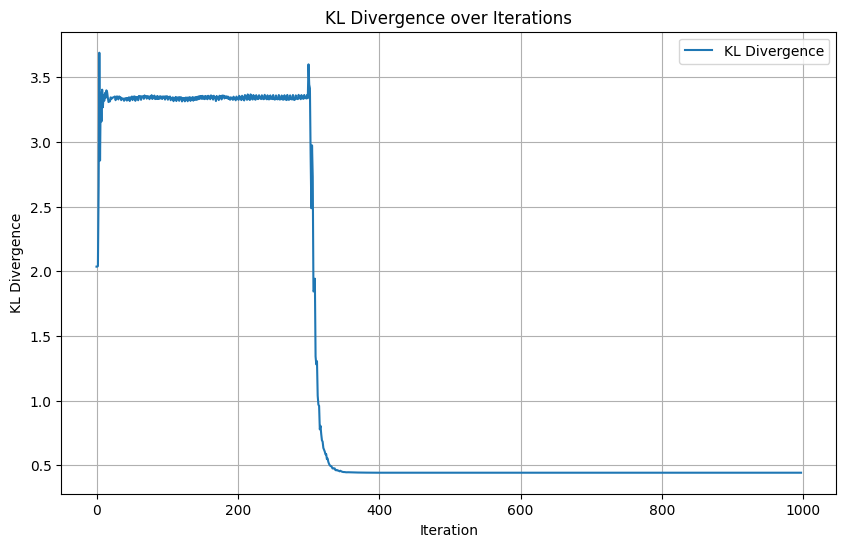

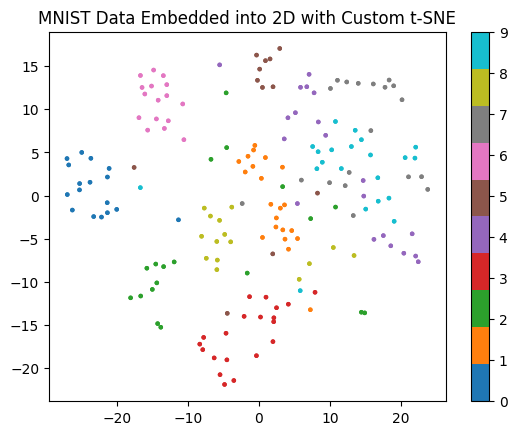

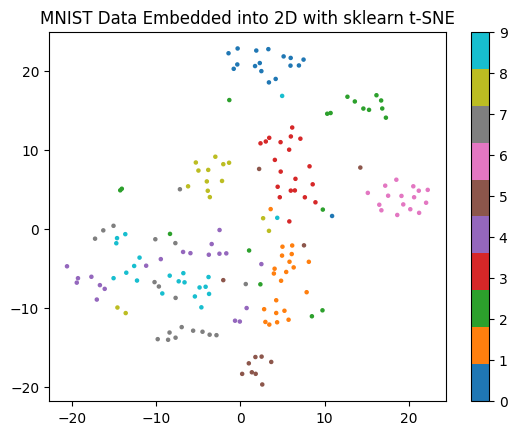

In [6]:
# Run your custom t-SNE implementation
custom_tsne = CustomTSNE(n_components=2, perplexity=N/10)
custom_Y = custom_tsne.fit_transform(X_train)
# Run sklearn t-SNE
sk_tsne = TSNE(n_components=2, perplexity=N/10)
sk_Y = sk_tsne.fit_transform(X_train)

# Visualization of the result
plt.figure()
plt.scatter(custom_Y[:, 0], custom_Y[:, 1], s=5, c=label_train.astype(int), cmap='tab10')
plt.scatter(custom_Y[:, 0], custom_Y[:, 1], s=5, c=label_train.astype(int), cmap='tab10')
plt.colorbar()
plt.title('MNIST Data Embedded into 2D with Custom t-SNE')

plt.figure()
plt.scatter(sk_Y[:, 0], sk_Y[:, 1], s=5, c=label_train.astype(int), cmap='tab10')
plt.colorbar()
plt.title('MNIST Data Embedded into 2D with sklearn t-SNE')
plt.show()

**Optimization process analysis:**  
When looking at the cost versus iterations plot, we observe that from the first iteration to iteration 50 there was an increase in the kl divergence value. Then, from iteration 50 to iteration 350, the cost function stays around 3.3 which indicates that the algorithm was looking for the direction towards the minimum but hadn't found it yet. After iteration 350, the dramatic drop on the cost indicates that the algorithm learned. From iteration 350 onwards, the cost stagnates which indicates convergence of the algorithm and a good embedding.

**Visual analysis:**  
From a visual perspective, we can see that for both our custom t-sne implementation and the scikit learn implementation on the MINST dataset show clear clusters for the categories 0, 3, 5 and 6. There appears to be some overlapping between 4, 7 and 9 for both implementations, which is understandable because these numbers have similar shapes (if the bottom part of the 4 is written with a small curve then it can be confused for a 9 and if the 7 is written with a bar in the middle it can be confused with a 4). Also, for both implementations, we can see that for the cluster 5 there are some outliers that appear close to 3 and 6. This also makes sense because if the bottom part of the 5 is drawn in almost a circle then the number will look closer to 6. Overall, even though the way the points are scattered over the graph is different for both implementations, the density of the clusters and the overlapping between them is similar for both implementations.

**Stability analysis:**  
Another way to evaluate the performance of the custom t-SNE implementation and the scikit learn implementation is to calculate their stability. That is, running the algorithm multiple times for each implementation and observing how consistent the results in the low dimensional space are by calculating the kentall tau distance. This metric compares the ordering of distances within the embeddings (similarity between embeddings) so that a lower kendall tau distance indicates less change in the order of distances between different runs and therefore higher stability.

In [7]:
from scipy.stats import kendalltau
from scipy.spatial.distance import pdist, squareform

In [8]:
def calculate_kendall_tau_distance(matrix1, matrix2):
    """
    This function calculates the Kendall tau distance between two distance matrices
    """
    # Get the indices of the entries above the diagonal of matrix 1 to avoid redundant calculations
    triu_indices = np.triu_indices_from(matrix1, k=1)
    # Extract the upper triangle values from both matrices
    rank1 = matrix1[triu_indices]
    rank2 = matrix2[triu_indices]
    # Get the kendall tau correlation coefficient
    tau, _ = kendalltau(rank1, rank2)
    # The distance is 1-tau: distance of 0 is perfect correlation, distance of 1 means no correlation/complete disagreement
    distance = 1 - tau
    return distance

In [9]:
def evaluate_tsne_stability(data, custom_tsne_params, sklearn_tsne_params, n_runs=10):
    """
    This function does several runs of both t-sne implementations (custom and scikit learn) and calculates the kendall tau distance of each comparison of runs (run 1 vs run 2, etc) to evaluate the stability of the t-sne algorithm implementations.
    Inputs:
        data: original dimensional data
        custom_tsne_params: parameters for the custom t-sne implementation
        sklearn_tsne_params: parameters for the sklearn t-sne implementation
        n_runs: amount of runs to be performed. Notice that for 10 runs and comparing 2 runs each time means C(10,2)=45 different comparisons.
    Returns:
        custom_embeddings: embeddings of the custom implementation
        sklearn_embeddings: embeddings of the scikit learn implementation
        average_custom_distance: the average between the kendall tau distances obtained for the custom implementation
        average_sklearn_distance: the average between the kendall tau distances obtained for the scikit learn implementation
    """

    custom_embeddings = []
    sklearn_embeddings = []
    custom_distance_matrices = []
    sklearn_distance_matrices = []
    custom_distances = []
    sklearn_distances = []
    labels = []

    # Run both t-SNE implementations 10 times and store the resulting embeddings
    for i in range(n_runs):
        custom_tsne = CustomTSNE(**custom_tsne_params)
        sklearn_tsne = TSNE(**sklearn_tsne_params)

        custom_embedding = custom_tsne.fit_transform(data)
        sklearn_embedding = sklearn_tsne.fit_transform(data)

        custom_embeddings.append(custom_embedding)
        sklearn_embeddings.append(sklearn_embedding)

        custom_distance_matrices.append(squareform(pdist(custom_embedding)))
        sklearn_distance_matrices.append(squareform(pdist(sklearn_embedding)))

    # Calculate the Kendall tau distance between all pairs of embeddings
    for i in range(n_runs):
        for j in range(i + 1, n_runs):
            custom_distance = calculate_kendall_tau_distance(custom_distance_matrices[i], custom_distance_matrices[j])
            sklearn_distance = calculate_kendall_tau_distance(sklearn_distance_matrices[i], sklearn_distance_matrices[j])
            custom_distances.append(custom_distance)
            sklearn_distances.append(sklearn_distance)
            labels.append(f"Run {i+1} vs Run {j+1}")

    # Calculate the average distance for each implementation
    average_custom_distance = np.mean(custom_distances)
    average_sklearn_distance = np.mean(sklearn_distances)
    print(f"Average Custom t-SNE Kendall tau distance: {average_custom_distance}")
    print(f"Average Scikit-learn t-SNE Kendall tau distance: {average_sklearn_distance}")

    # Plot the Kendall tau distances with labels
    plt.figure(figsize=(14, 6))
    plt.plot(custom_distances, label='Custom t-SNE', marker='o')
    plt.plot(sklearn_distances, label='Scikit-learn t-SNE', linestyle='--', marker='x')
    plt.xticks(ticks=np.arange(len(labels)), labels=labels, rotation=90)
    plt.xlabel('Run Comparisons')
    plt.ylabel('Kendall Tau Distance')
    plt.title('Kendall Tau Distances Between t-SNE Runs')
    plt.legend()
    plt.tight_layout()
    plt.show()

    average_custom_distance = np.mean(custom_distances)
    average_sklearn_distance = np.mean(sklearn_distances)

    return custom_embeddings, sklearn_embeddings, average_custom_distance, average_sklearn_distance

# Define parameters and data as before
custom_tsne_params = {
    'perplexity': 30,
    'n_components': 2,
    'n_iter': 1000,
    'learning_rate': 200,
    'early_exaggeration': 12
}
sklearn_tsne_params = {
    'perplexity': 30,
    'n_components': 2,
    'n_iter': 1000,
    'learning_rate': 200,
    'random_state': None,
    'early_exaggeration': 12
}


<ipython-input-3-d26f7698a5c5>:50: RuntimeWarning: invalid value encountered in divide
  p_new = np.maximum(p / np.sum(p), epsilon)


Iteration 1: Value of Cost Function is 1.6474674732573746
Iteration 50: Value of Cost Function is 3.3787234791842584
Iteration 100: Value of Cost Function is 3.4156781511958383
Iteration 150: Value of Cost Function is 3.4424527418202024
Iteration 200: Value of Cost Function is 3.4216400560328246
Iteration 250: Value of Cost Function is 3.369724220314282
Iteration 300: Value of Cost Function is 3.394471585186435
Iteration 350: Value of Cost Function is 0.47033057615918583
Iteration 400: Value of Cost Function is 0.4509377607363706
Iteration 450: Value of Cost Function is 0.4509086131242191
Iteration 500: Value of Cost Function is 0.45090875550024423
Iteration 550: Value of Cost Function is 0.4509087556080613
Iteration 600: Value of Cost Function is 0.4509087556084401
Iteration 650: Value of Cost Function is 0.4509087556084375
Iteration 700: Value of Cost Function is 0.45090875560843746
Iteration 750: Value of Cost Function is 0.4509087556084373
Iteration 800: Value of Cost Function is 0

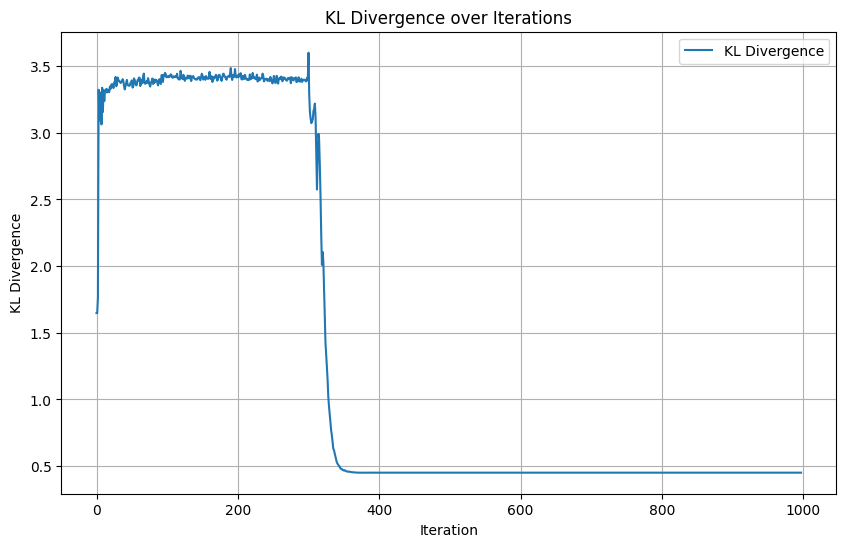

<ipython-input-3-d26f7698a5c5>:50: RuntimeWarning: invalid value encountered in divide
  p_new = np.maximum(p / np.sum(p), epsilon)


Iteration 1: Value of Cost Function is 1.6474674718399624
Iteration 50: Value of Cost Function is 3.457264888941835
Iteration 100: Value of Cost Function is 3.4126090562401576
Iteration 150: Value of Cost Function is 3.417552587292103
Iteration 200: Value of Cost Function is 3.4003709816240466
Iteration 250: Value of Cost Function is 3.3986581664178637
Iteration 300: Value of Cost Function is 3.4277269900799463
Iteration 350: Value of Cost Function is 0.4469814019949814
Iteration 400: Value of Cost Function is 0.4025047723986498
Iteration 450: Value of Cost Function is 0.40249665460656214
Iteration 500: Value of Cost Function is 0.40249677920125726
Iteration 550: Value of Cost Function is 0.4024967794071485
Iteration 600: Value of Cost Function is 0.4024967794056482
Iteration 650: Value of Cost Function is 0.40249677940565254
Iteration 700: Value of Cost Function is 0.40249677940565254
Iteration 750: Value of Cost Function is 0.40249677940565254
Iteration 800: Value of Cost Function is

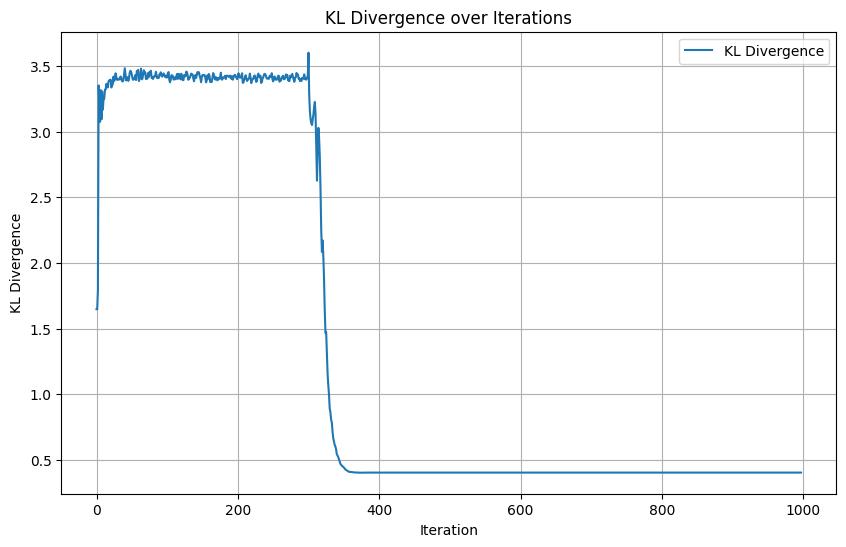

<ipython-input-3-d26f7698a5c5>:50: RuntimeWarning: invalid value encountered in divide
  p_new = np.maximum(p / np.sum(p), epsilon)


Iteration 1: Value of Cost Function is 1.6474674733679424
Iteration 50: Value of Cost Function is 3.3469689447118887
Iteration 100: Value of Cost Function is 3.4007233275436635
Iteration 150: Value of Cost Function is 3.3812969497765613
Iteration 200: Value of Cost Function is 3.3841334666889877
Iteration 250: Value of Cost Function is 3.4019634309475895
Iteration 300: Value of Cost Function is 3.3936888188004835
Iteration 350: Value of Cost Function is 0.45513070651300747
Iteration 400: Value of Cost Function is 0.4224244575384547
Iteration 450: Value of Cost Function is 0.4173966672454432
Iteration 500: Value of Cost Function is 0.41744556775665725
Iteration 550: Value of Cost Function is 0.417445286474126
Iteration 600: Value of Cost Function is 0.4174452878061517
Iteration 650: Value of Cost Function is 0.4174452878118155
Iteration 700: Value of Cost Function is 0.417445287811808
Iteration 750: Value of Cost Function is 0.417445287811808
Iteration 800: Value of Cost Function is 0.4

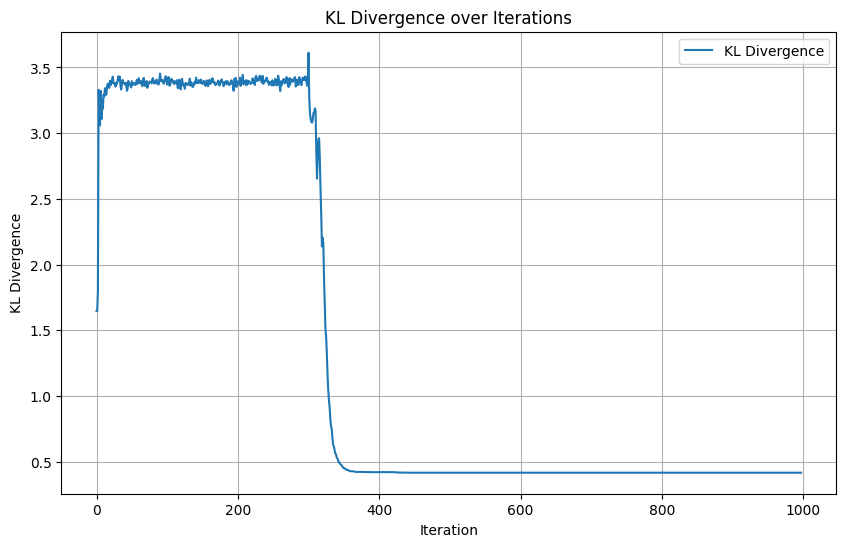

<ipython-input-3-d26f7698a5c5>:50: RuntimeWarning: invalid value encountered in divide
  p_new = np.maximum(p / np.sum(p), epsilon)


Iteration 1: Value of Cost Function is 1.6474674725050482
Iteration 50: Value of Cost Function is 3.423057015486243
Iteration 100: Value of Cost Function is 3.441763292575558
Iteration 150: Value of Cost Function is 3.476009951583118
Iteration 200: Value of Cost Function is 3.4464637945508354
Iteration 250: Value of Cost Function is 3.3954141896918424
Iteration 300: Value of Cost Function is 3.4124168215887307
Iteration 350: Value of Cost Function is 0.4327167089939731
Iteration 400: Value of Cost Function is 0.41655415071132257
Iteration 450: Value of Cost Function is 0.4164805906295777
Iteration 500: Value of Cost Function is 0.4164803664210737
Iteration 550: Value of Cost Function is 0.4164803648839926
Iteration 600: Value of Cost Function is 0.4164803648572118
Iteration 650: Value of Cost Function is 0.41648036485681217
Iteration 700: Value of Cost Function is 0.4164803648568064
Iteration 750: Value of Cost Function is 0.4164803648568065
Iteration 800: Value of Cost Function is 0.4

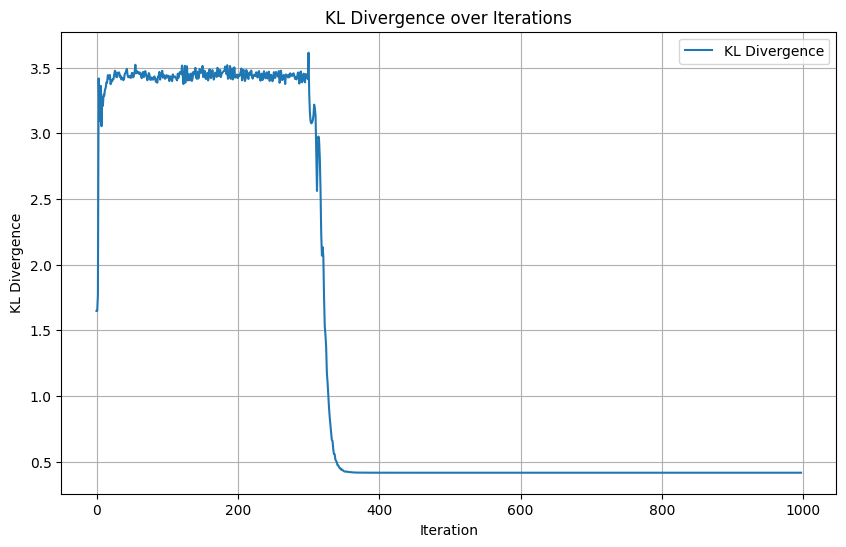

<ipython-input-3-d26f7698a5c5>:50: RuntimeWarning: invalid value encountered in divide
  p_new = np.maximum(p / np.sum(p), epsilon)


Iteration 1: Value of Cost Function is 1.647467471050469
Iteration 50: Value of Cost Function is 3.3946566303348638
Iteration 100: Value of Cost Function is 3.3732804123134317
Iteration 150: Value of Cost Function is 3.4003513495699917
Iteration 200: Value of Cost Function is 3.4163185408344607
Iteration 250: Value of Cost Function is 3.371071101464188
Iteration 300: Value of Cost Function is 3.3838732425990443
Iteration 350: Value of Cost Function is 0.4554293125792745
Iteration 400: Value of Cost Function is 0.4310166926864016
Iteration 450: Value of Cost Function is 0.4270421464984151
Iteration 500: Value of Cost Function is 0.426238359302215
Iteration 550: Value of Cost Function is 0.42623298860783726
Iteration 600: Value of Cost Function is 0.42623294260183875
Iteration 650: Value of Cost Function is 0.42623294208134876
Iteration 700: Value of Cost Function is 0.42623294207640416
Iteration 750: Value of Cost Function is 0.4262329420763554
Iteration 800: Value of Cost Function is 0

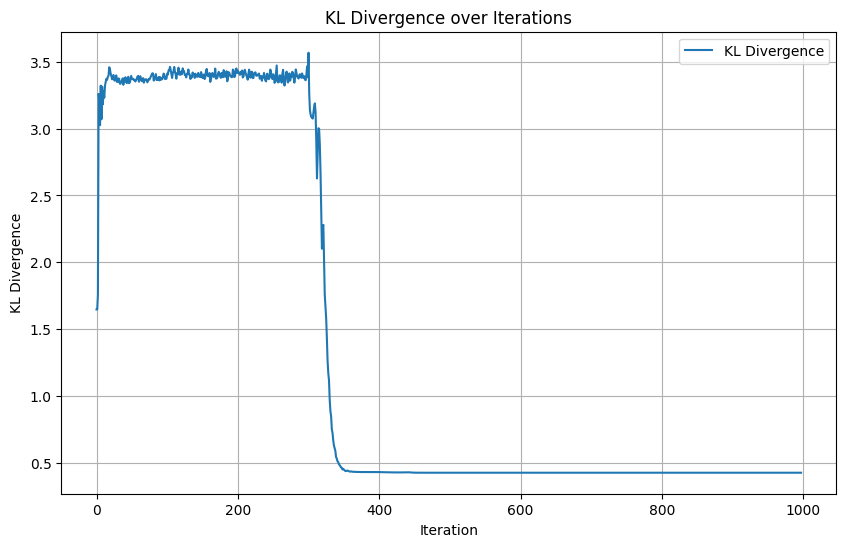

<ipython-input-3-d26f7698a5c5>:50: RuntimeWarning: invalid value encountered in divide
  p_new = np.maximum(p / np.sum(p), epsilon)


Iteration 1: Value of Cost Function is 1.6474674714867727
Iteration 50: Value of Cost Function is 3.4126053022547307
Iteration 100: Value of Cost Function is 3.4077788860292264
Iteration 150: Value of Cost Function is 3.451899274714126
Iteration 200: Value of Cost Function is 3.411295071709455
Iteration 250: Value of Cost Function is 3.4630800871260465
Iteration 300: Value of Cost Function is 3.4189219794508556
Iteration 350: Value of Cost Function is 0.46322147579054257
Iteration 400: Value of Cost Function is 0.4301462585966406
Iteration 450: Value of Cost Function is 0.4301583928480362
Iteration 500: Value of Cost Function is 0.4301585631588164
Iteration 550: Value of Cost Function is 0.43015856296823246
Iteration 600: Value of Cost Function is 0.4301585629679564
Iteration 650: Value of Cost Function is 0.4301585629679597
Iteration 700: Value of Cost Function is 0.43015856296795985
Iteration 750: Value of Cost Function is 0.43015856296795985
Iteration 800: Value of Cost Function is 

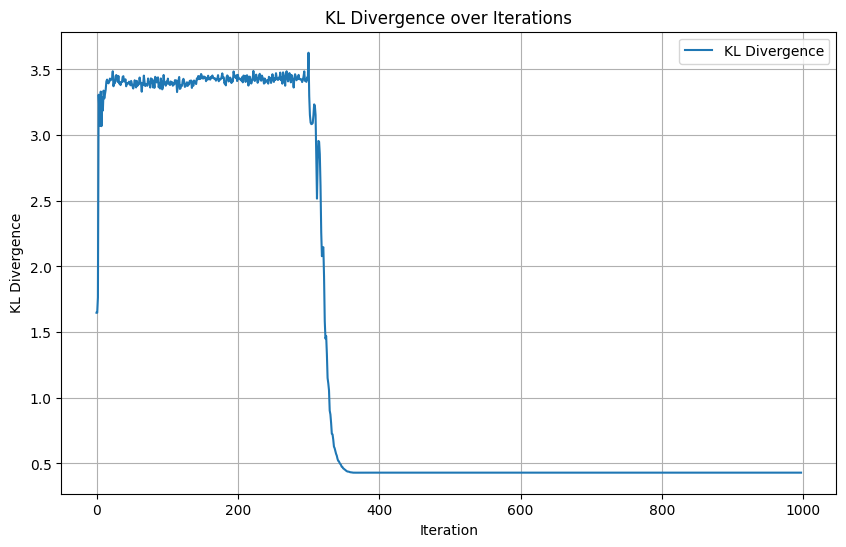

<ipython-input-3-d26f7698a5c5>:50: RuntimeWarning: invalid value encountered in divide
  p_new = np.maximum(p / np.sum(p), epsilon)


Iteration 1: Value of Cost Function is 1.6474674721506524
Iteration 50: Value of Cost Function is 3.4308140218460172
Iteration 100: Value of Cost Function is 3.474566216265281
Iteration 150: Value of Cost Function is 3.5103486513112108
Iteration 200: Value of Cost Function is 3.440872175050491
Iteration 250: Value of Cost Function is 3.4453653678261738
Iteration 300: Value of Cost Function is 3.500576855551694
Iteration 350: Value of Cost Function is 0.4514456557771963
Iteration 400: Value of Cost Function is 0.4257208940775667
Iteration 450: Value of Cost Function is 0.4257186034099192
Iteration 500: Value of Cost Function is 0.4257186224913241
Iteration 550: Value of Cost Function is 0.42571862248790604
Iteration 600: Value of Cost Function is 0.425718622485331
Iteration 650: Value of Cost Function is 0.4257186224853426
Iteration 700: Value of Cost Function is 0.4257186224853424
Iteration 750: Value of Cost Function is 0.42571862248534253
Iteration 800: Value of Cost Function is 0.42

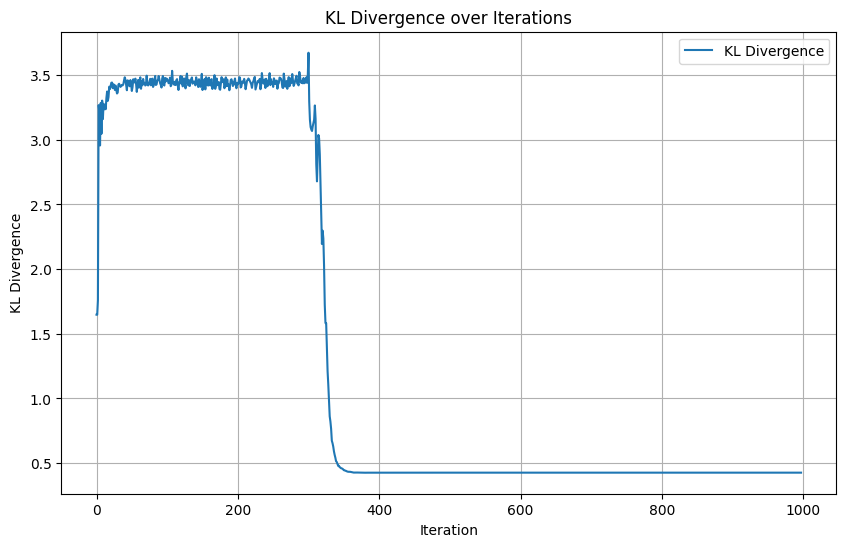

<ipython-input-3-d26f7698a5c5>:50: RuntimeWarning: invalid value encountered in divide
  p_new = np.maximum(p / np.sum(p), epsilon)


Iteration 1: Value of Cost Function is 1.64746747081846
Iteration 50: Value of Cost Function is 3.375640170999966
Iteration 100: Value of Cost Function is 3.3972317100107587
Iteration 150: Value of Cost Function is 3.3887712392007177
Iteration 200: Value of Cost Function is 3.4045425063688457
Iteration 250: Value of Cost Function is 3.377916352301634
Iteration 300: Value of Cost Function is 3.383765675762888
Iteration 350: Value of Cost Function is 0.44586469827207675
Iteration 400: Value of Cost Function is 0.4169827811470736
Iteration 450: Value of Cost Function is 0.41710468732852707
Iteration 500: Value of Cost Function is 0.4171043035300613
Iteration 550: Value of Cost Function is 0.4171043026922059
Iteration 600: Value of Cost Function is 0.41710430269801585
Iteration 650: Value of Cost Function is 0.4171043026980147
Iteration 700: Value of Cost Function is 0.41710430269801463
Iteration 750: Value of Cost Function is 0.4171043026980146
Iteration 800: Value of Cost Function is 0.4

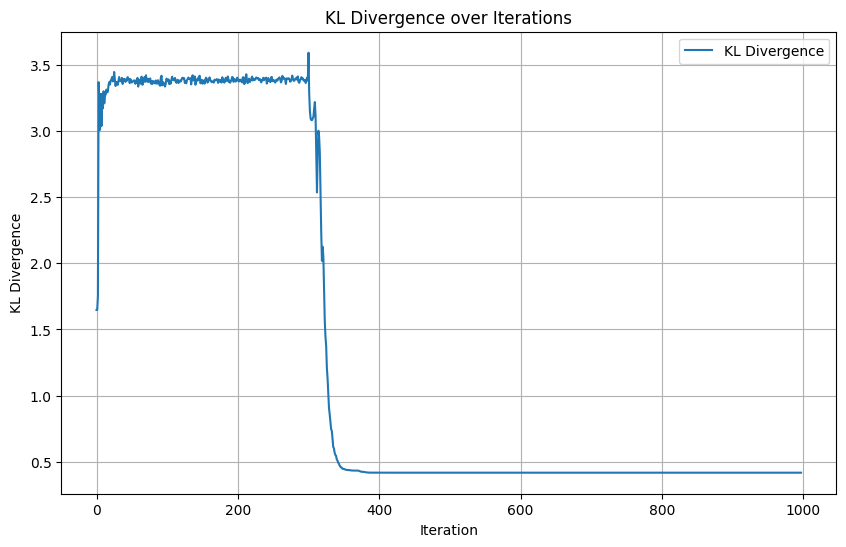

<ipython-input-3-d26f7698a5c5>:50: RuntimeWarning: invalid value encountered in divide
  p_new = np.maximum(p / np.sum(p), epsilon)


Iteration 1: Value of Cost Function is 1.6474674739420847
Iteration 50: Value of Cost Function is 3.360109727568706
Iteration 100: Value of Cost Function is 3.393490262277131
Iteration 150: Value of Cost Function is 3.450300328901616
Iteration 200: Value of Cost Function is 3.408778746500656
Iteration 250: Value of Cost Function is 3.4225065010404796
Iteration 300: Value of Cost Function is 3.4051528964959648
Iteration 350: Value of Cost Function is 0.44867751380666426
Iteration 400: Value of Cost Function is 0.4255595328267506
Iteration 450: Value of Cost Function is 0.4254612235743117
Iteration 500: Value of Cost Function is 0.42545968247906774
Iteration 550: Value of Cost Function is 0.42545963951137755
Iteration 600: Value of Cost Function is 0.425459638393366
Iteration 650: Value of Cost Function is 0.4254596383643442
Iteration 700: Value of Cost Function is 0.4254596383635897
Iteration 750: Value of Cost Function is 0.4254596383635701
Iteration 800: Value of Cost Function is 0.42

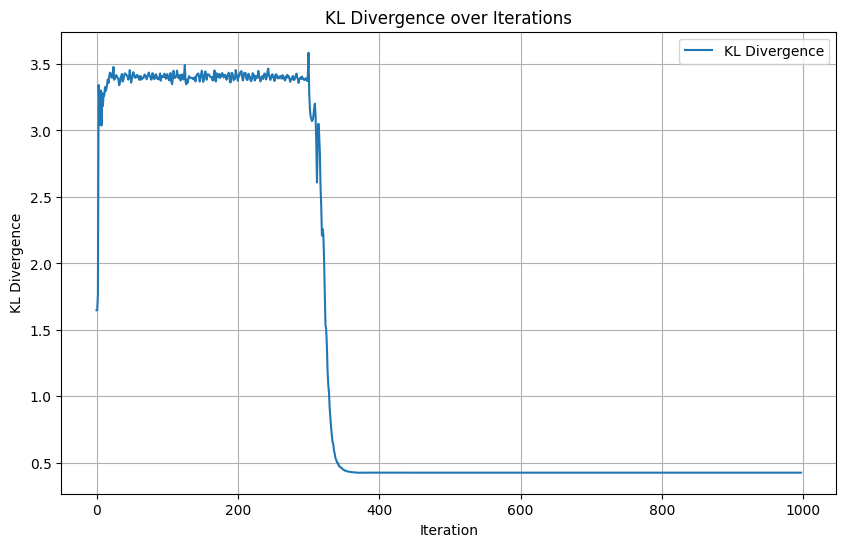

<ipython-input-3-d26f7698a5c5>:50: RuntimeWarning: invalid value encountered in divide
  p_new = np.maximum(p / np.sum(p), epsilon)


Iteration 1: Value of Cost Function is 1.6474674740548922
Iteration 50: Value of Cost Function is 3.4152703679556673
Iteration 100: Value of Cost Function is 3.4031577172536758
Iteration 150: Value of Cost Function is 3.4074417063688385
Iteration 200: Value of Cost Function is 3.4006875450335596
Iteration 250: Value of Cost Function is 3.3957735347084066
Iteration 300: Value of Cost Function is 3.372917803326384
Iteration 350: Value of Cost Function is 0.42611497413369026
Iteration 400: Value of Cost Function is 0.410397315568518
Iteration 450: Value of Cost Function is 0.4103670175942133
Iteration 500: Value of Cost Function is 0.4103670630172985
Iteration 550: Value of Cost Function is 0.41036706342601
Iteration 600: Value of Cost Function is 0.41036706342513063
Iteration 650: Value of Cost Function is 0.41036706342512885
Iteration 700: Value of Cost Function is 0.41036706342512885
Iteration 750: Value of Cost Function is 0.410367063425129
Iteration 800: Value of Cost Function is 0.4

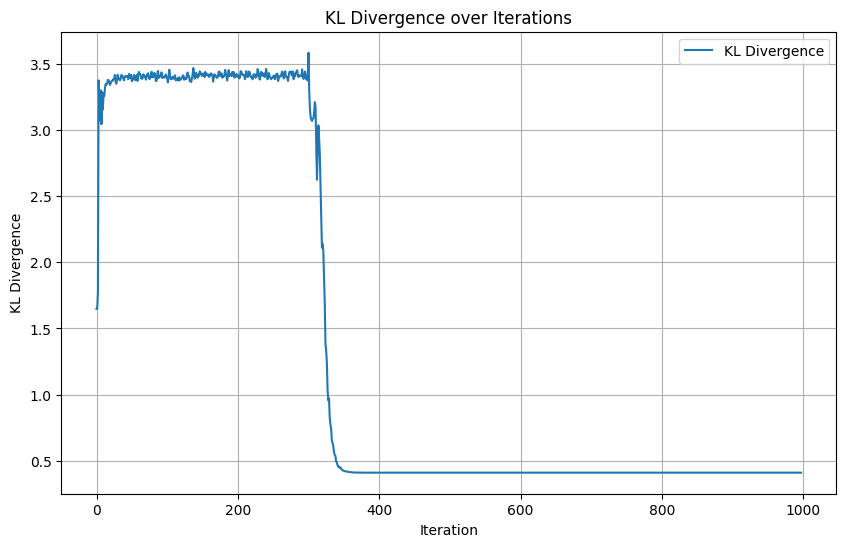

Average Custom t-SNE Kendall tau distance: 0.33392741276216203
Average Scikit-learn t-SNE Kendall tau distance: 0.4625446073241533


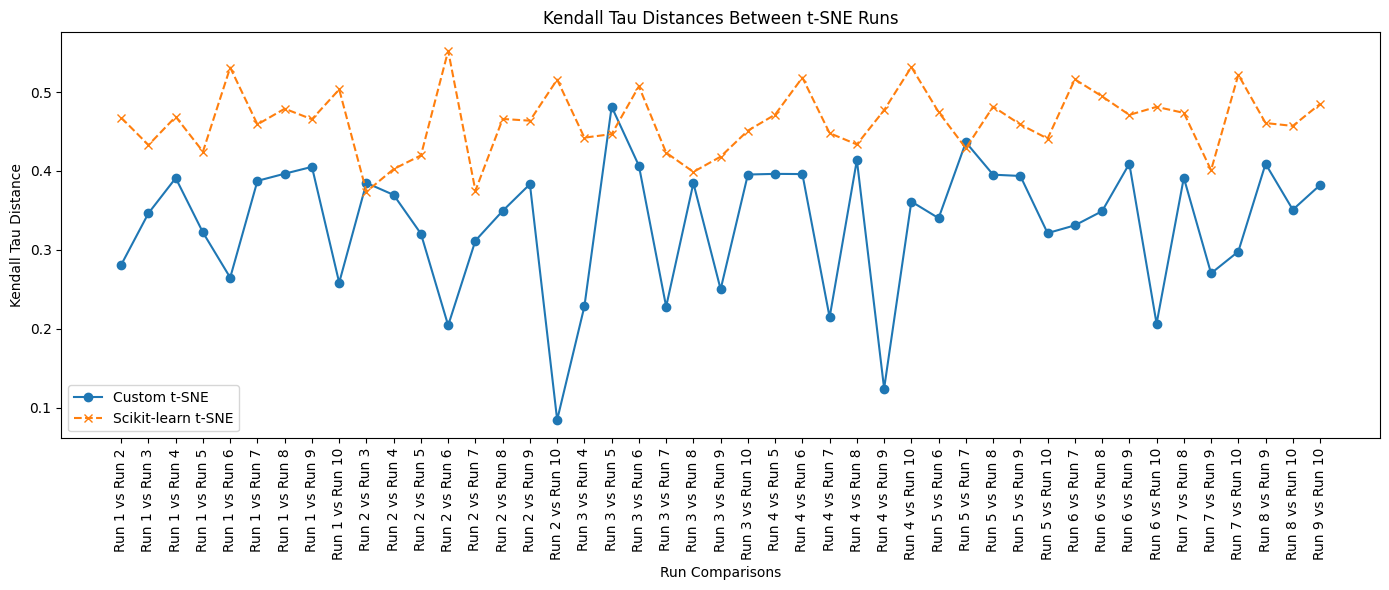

In [10]:
# Evaluate stability of both implementations
data = X_train
custom_embeddings, sklearn_embeddings, avg_custom_distance, avg_sklearn_distance = evaluate_tsne_stability(data, custom_tsne_params, sklearn_tsne_params)

The average kendall tau distance is higher for the scikit learn implementation than for the custom t-sne implementation. Indeed, the plot shows that for the majority of the comparison of runs, custom t-sne achieves a smaller kendall tau distance than scikit learn t-sne. A smaller distance is interpreted as a higher kendall tau correlation which means there were less disagreements between the rankings (each ranking corresponds to the order of distances between points in the t-sne embeddings accross different runs). Hence, for the custom t-sne implementation, we obtain less change in the order of distances between different runs, which means that this implementation is relatively more stable in terms of producing consistent results on the same dataset and with the same parameters, than the scikit learn implementation.

# t-SNE extension - mapping new samples
Demonstrate your t-SNE transformation procedure.
Add plots and figures if needed.
Please use this cell to describe your suggested approach in details. Use formal notations where appropriate.
Describe and discuss your results.

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but NearestNeighbors was fitted without feature names
  warnings.warn(


Text(0.5, 1.0, 'MNIST Data Embedded into 2D with Custom t-SNE')

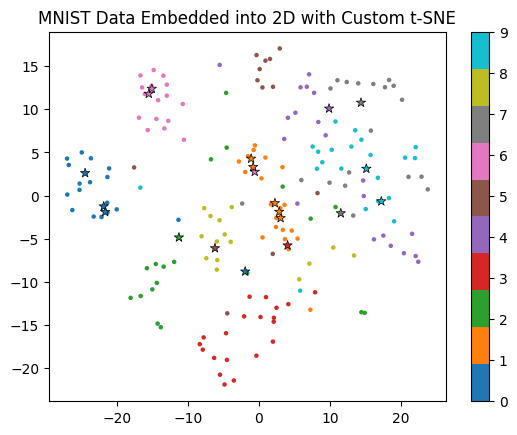

In [11]:
# Transform new data
custom_Y_new = custom_tsne.transform(X_train,custom_Y,X_test)

# Visualization of the result
plt.figure()
plt.scatter(custom_Y[:, 0], custom_Y[:, 1], s=5, c=label_train.astype(int), cmap='tab10')
plt.scatter(custom_Y_new[:, 0], custom_Y_new[:, 1], marker = '*', s=50, linewidths=0.5, edgecolors='k', c=label_test.astype(int), cmap='tab10')
plt.colorbar()
plt.title('MNIST Data Embedded into 2D with Custom t-SNE')

## Part 2

Question 1: Extending t-SNE to include new points in the precomputed 2D map essentially means adding new data points into an existing t-SNE projection without recomputing the entire projection from scratch. for that we will use UMAP: a dimensionality reduction technique some what similar to t-SNE. UMAP is known for its scalability and ability to handle large datasets efficiently, making it suitable for extending t-SNE projections with new data points.

In [17]:
!pip install umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 3.4 MB/s eta 0:00:00


In [18]:
from umap.umap_ import UMAP

In [14]:
# Here we compute the initial t-SNE projection without cahnges.
tsne = TSNE(n_components=2, random_state=42)
tsne_projection = tsne.fit_transform(np.concatenate((X_train, X_test)))

In [19]:
# Here we add new data points using umap
umap = UMAP(n_components=2, random_state=42)
umap_projection = umap.fit_transform(X)

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [20]:
# Here we Combine the original and new data points with the umap
combined_projection = np.concatenate((tsne_projection, umap_projection))

In [21]:
# Separate the combined projection into original and new data points
combined_tsne_projection = combined_projection[:len(tsne_projection)]
combined_umap_projection = combined_projection[len(tsne_projection):]

The next cell represents the shape of the combined projection obtained by concatenating the t-SNE and UMAP projections. Since both t-SNE and UMAP projections have the same number of dimensions: 2.

The combined projection would have a shape of (total number of data points, 2).

In [22]:
# Get the shapes
print("Original t-SNE projection shape:", tsne_projection.shape)
print("UMAP projection shape:", umap_projection.shape)
print("Combined projection shape:", combined_projection.shape)

Original t-SNE projection shape: (200, 2)
UMAP projection shape: (200, 2)
Combined projection shape: (400, 2)


The umap approach is good for the transformation of the data due to its ability to handle larger datasets more efficiently compared to t-SNE.
By using UMAP, we can analyze and visualize large datasets more quickly and with less computational resources.

Question 2:

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but NearestNeighbors was fitted without feature names
  warnings.warn(


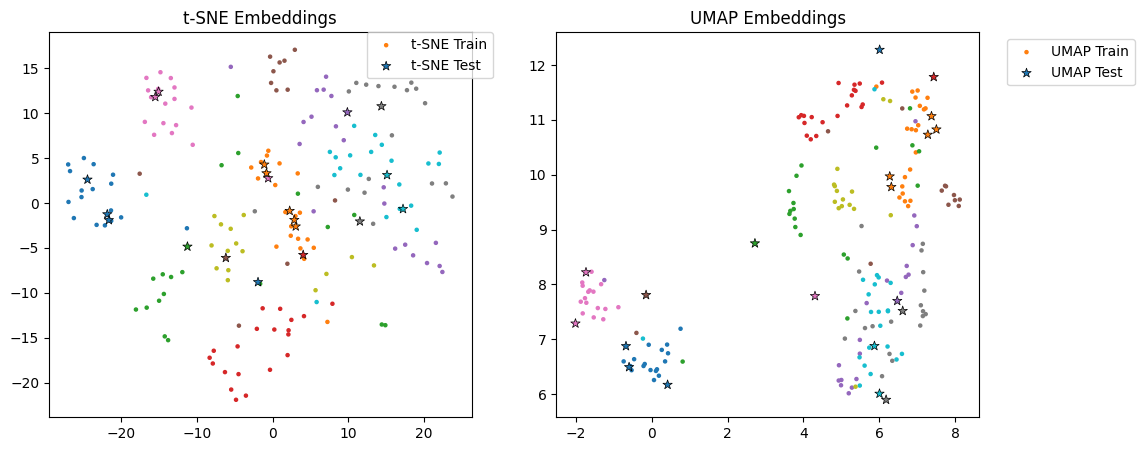

In [23]:
# here we fit the UMAP to our training data and transform the test set using the trained UMAP model
umap_model = UMAP(n_components=2, n_neighbors=15, min_dist=0.1)
umap_embeddings = umap_model.fit_transform(X_train)
umap_embeddings_test = umap_model.transform(X_test)

custom_Y_new = custom_tsne.transform(X_train, custom_Y, X_test)

# subplots of t-sne and umap
plt.figure(figsize=(12, 5))

# Plot t-SNE embeddings
plt.subplot(1, 2, 1)
plt.scatter(custom_Y[:, 0], custom_Y[:, 1], s=5, c=label_train.astype(int), cmap='tab10', label='t-SNE Train')
plt.scatter(custom_Y_new[:, 0], custom_Y_new[:, 1], marker='*', s=50, linewidths=0.5, edgecolors='k', c=label_test.astype(int), cmap='tab10', label='t-SNE Test')
plt.title('t-SNE Embeddings')
plt.legend(loc='upper right', bbox_to_anchor=(1.05, 1), borderaxespad=0)

# Plot UMAP embeddings
plt.subplot(1, 2, 2)
plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], s=5, c=label_train.astype(int), cmap='tab10', label='UMAP Train')
plt.scatter(umap_embeddings_test[:, 0], umap_embeddings_test[:, 1], marker='*', s=50, linewidths=0.5, edgecolors='k', c=label_test.astype(int), cmap='tab10', label='UMAP Test')
plt.title('UMAP Embeddings')
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))

plt.show()

Question 3:

For evaluationg the quality of the transformation procedure we chose to use trustworthiness score as it is a measure commonly used to evaluate the quality of low-dimensional embeddings, such as those produced by dimensionality reduction techniques like t-SNE and UMAP.

The trustworthiness score assesses how well the local structure of the original high-dimensional data is preserved in the low-dimensional embedding. The score ranges from 0 to 1, where a higher score indicates better preservation of local relationships between data points.

We call the trustworthiness score and to assess the trustworthiness of the low-dimensional embedding we chose 7 as the number of nearest neighbors in the original high-dimensional space to compare with the nearest neighbors in the low-dimensional embedding. 7 wasnt high or low.

In [24]:
from sklearn.manifold import trustworthiness

In [25]:
# trustworthiness score for t-SNE
trustworthiness_tsne = trustworthiness(X_test, custom_Y_new, n_neighbors=7)

# trustworthiness score for UMAP
trustworthiness_umap = trustworthiness(X_test, umap_embeddings_test, n_neighbors=7)

print("Trustworthiness score for t-SNE:", trustworthiness_tsne)
print("Trustworthiness score for UMAP:", trustworthiness_umap)

Trustworthiness score for t-SNE: 0.8269841269841269
Trustworthiness score for UMAP: 0.7817460317460317


Both t-SNE and UMAP got relatively high trustworthiness scores, suggesting that they are effective at preserving the local structure of the MNIST dataset in the low-dimensional embeddings.
The t-SNE embedding appears to have a slightly higher trustworthiness score compared to UMAP in this particular experiment.